In [1]:
from astropy.table import Table
import seaborn as sns
sns.set()

In [2]:
dr7sdss = Table.read('LERGs.fits')
dr7sdss = dr7sdss.to_pandas()
dr7sdss.columns

Index(['Z', 'Z_ERR', 'SMASS_MEDIAN', 'D4000', 'O3F', 'N2F', 'HBF', 'HAF',
       'O3F_ERR', 'N2F_ERR', 'HBF_ERR', 'HAF_ERR', 'O3HB', 'N2HA', 'ABSU',
       'ABSG', 'ABSR', 'ABSI', 'ABSZ', 'w1mpro', 'w1sigmpro', 'w2mpro',
       'w2sigmpro', 'w3mpro', 'w3sigmpro', 'w4mpro', 'w4sigmpro'],
      dtype='object')

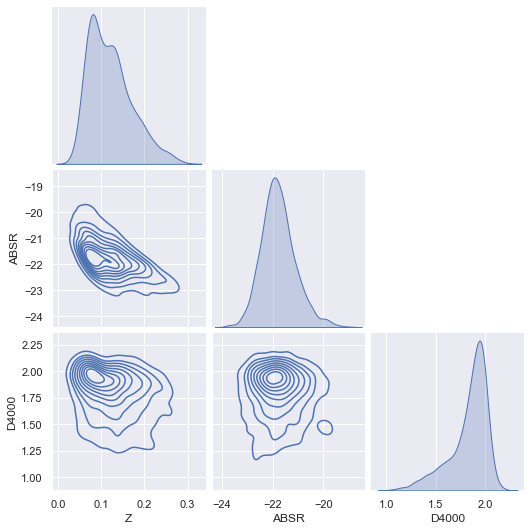

In [16]:
sns.pairplot(data=dr7sdss, vars=['Z','ABSR','D4000'], kind="kde", corner=True)

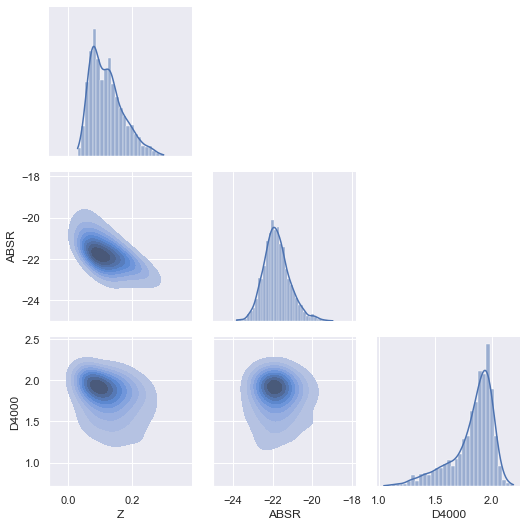

In [3]:
g = sns.PairGrid(dr7sdss, vars=['Z','ABSR','D4000'], corner=True)
g.map_lower(sns.kdeplot, fill=True, bw_adjust=2)
g.map_diag(sns.histplot, kde=True)

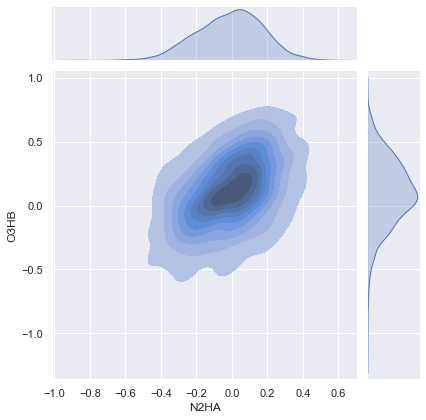

In [14]:
sns.jointplot(data=dr7sdss, x="N2HA", y="O3HB", kind="kde", fill=True)